# Information Retrieval Project
## COVID-19 Search Engine (P12)

Content-based image retrieval (CBIR) is a computer vision technique which addresses the problem of searching for digital images in large databases. A content-based approach exploits the contents of an image, such as colors, shapes and textures, differing from its concept-based counterpart, which instead focuses on keywords and tags associated with the image itself.

Image retrieval has gained more and more relevance in the medical field, due to the accumulation of extensive collections of scans in hospitals. These images are stored in DICOM format, which must be manually annotated and may require considerable time to process by physicians. The goal of this project is trying to address this problem by considering different approaches for building a content-based medical image retrieval system and comparing their results based on classification metrics and computational time.

# Installation of Requirements

This part of the code installs necessary dependencies specified in the `requirements.txt` file.
Utilizes the `!pip install -r requirements.txt` command to install packages listed in the `requirements.txt` file. This ensures that all required dependencies are installed before proceeding with execution.


In [1]:
!pip install -r requirements.txt

# Importing Required Libraries

This part of the code imports necessary libraries.

In [1]:
# *********************************** #
# ************** IMPORT ************* #
# *********************************** #
import os
import glob
import kaggle
import imagehash

import numpy as np
import pandas as pd
import matplotlib.image as mpimg

from keras.models import Model
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16, preprocess_input

from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_distances, euclidean_distances, manhattan_distances

from matplotlib import pyplot as plt
from PIL import Image, UnidentifiedImageError

from silence_tensorflow import silence_tensorflow

# Definition of constants

This part of the code defines useful constants and paths.

In [2]:
# ************************************** #
# ************** CONSTANTS ************* #
# ************************************** #

# PATHS
PROJECT_ROOT = os.getcwd()  # The project root
DATASET_PATH = "archives"  # Path to the dataset
DATASET_ID = "plameneduardo/sarscov2-ctscan-dataset"  # ID for Kaggle API. Format: dataset_owner_name/dataset_name
COVID_PATH = os.path.join(DATASET_PATH, "COVID")  # Path to data labeled as COVID
NON_COVID_PATH = os.path.join(DATASET_PATH, "non-COVID")  # Path to data labeled as non-COVID
DATA_PATH = "data"  # Path to the data folder 
PLOT_PATH = "plot"  # Path to the plot folder
DATAFRAME_PATH = os.path.join(DATA_PATH, "chest_ct_scan_table.csv")
TRAIN_DATA_PATH = os.path.join(DATA_PATH, "train_data.csv")
TEST_DATA_PATH = os.path.join(DATA_PATH, "test_data.csv")

# DATA, KERAS AND SIMILAR
CLASSES = ["COVID", "non-COVID"]
IMG_WIDTH = 224
IMG_HEIGHT = 224
IMG_SIZE = (IMG_HEIGHT, IMG_WIDTH)
CHANNELS = 3
BATCH_SIZE = 32
INPUT_SHAPE = (IMG_HEIGHT, IMG_WIDTH, CHANNELS)

# DISTANCE FUNCTIONS
EUCLIDEAN = "Euclidean"
COSINE = "Cosine"
MANHATTAN = "Manhattan"
JACCARD = "Jaccard"
HAMMING = "Hamming"

# Building the Workspace

Definition of useful directory and executing the dataset Download.

## Download dataset from Kaggle

If the dataset does not exist, the code proceeds to download it from Kaggle using the `kaggle.api.dataset_download_files()` function.


In [3]:
# Create a directory
def makedir(dir_path: str) -> None:
    """
    Create a directory, given a path

    :param dir_path: directory location
    
    :return: None
    """
    # check if dir exists
    if not os.path.exists(dir_path):
        os.makedirs(dir_path, exist_ok=True)
        print("\n> Directory [{}] has been created successfully!".format(dir_path))
        
        
# Download dataset from Kaggle website
def download_dataset_from_kaggle(dataset_id: str, dataset_path: str) -> None:
    """
    Download the sarscov2-ctscan-dataset using Kaggle module

    :param dataset_id: identify the dataset to download.
        Format: dataset_owner_name/dataset_name
    :param dataset_path: location to save the dataset

    :return: None
    """
    # Download the dataset if not exist in the workplace
    if not os.path.exists(path=dataset_path):
        
        print("\n> Download the dataset from Kaggle...")
        # Download dataset and unzip it
        kaggle.api.dataset_download_files(dataset=dataset_id, path=dataset_path, quiet=False, unzip=True)
    else:
        print("\n> Dataset already downloaded.")


## ************************************ DEFINING THE WORKSPACE ********************************** ##      

# Execute the download operation
download_dataset_from_kaggle(dataset_id=DATASET_ID, dataset_path=DATASET_PATH)

# Create data folder
makedir(DATA_PATH)

# Create plot folder
makedir(PLOT_PATH)


> Dataset already downloaded.


# Dataset Preprocessing Summary

This code performs preprocessing tasks on a dataset, which includes counting files, checking for corrupted files, filtering out duplicates, and plotting duplicate images alongside their originals.

## 1. Counting Files
The `count_files` function counts the number of files with specified extensions in a specified directory. It takes the directory path and file extensions as inputs and returns the count of files.

## 2. Checking for Corrupted Files
The `corruption_filter` function checks the dataset for corrupted image files and provides an option to delete them. It iterates through all files, verifies their integrity using PIL's `Image` module, and removes corrupted files if requested.

## 3. Finding and Handling Duplicates
The `find_out_duplicate` function identifies duplicate images within the dataset. It computes the hash of each image and compares it with previous hashes to detect duplicates. If duplicates are found, it plots each pair of original and duplicate images side by side using Matplotlib. The user is prompted to decide whether to delete the duplicate images.

## Usage
1. The code begins with checking the dataset's file count before preprocessing tasks.
2. It then checks for corrupted files and provides an option to delete them.
3. Next, it identifies and handles duplicates within the COVID and non-COVID dataset subdirectories.
4. Finally, it confirms the total file count after preprocessing.

This code ensures the integrity and cleanliness of the dataset for further analysis or model training.

In [4]:
# Count the number of files
def count_files(directory_path: str, extensions="png") -> int:
    """
    Count the number of files with specified extensions in the specified directory.

    Example: count_files("/path/to/directory", extensions=["jpg", "png"]) -> 12

    :param directory_path: (str) The path to the directory for which file count is required.
    :param extensions: (list or None) List of file extensions to count. If None, count all files.

    :return: (int) The number of files with specified extensions in the specified directory.
    """
    if extensions is None:
        # If no extensions provided, consider all files
        extensions = ['']
    
    # Initialize counter for files
    counter = 0 
    # Iterate over the directory
    with os.scandir(directory_path) as entries:
        for entry in entries:
             # Check if it's a file with specified extension
            if entry.is_file() and any(entry.name.lower().endswith(ext) for ext in extensions):
                counter += 1

    return counter


# Just a helper function
def print_file_counts() -> None:
    """
    A helper function that print information about the number of files inside the directory.
    
    :return: None
    """
    count_covid = count_files(directory_path=COVID_PATH)  # Count COVID files
    count_non_covid = count_files(directory_path=NON_COVID_PATH)  # Count non-COVID files
    
    # Total number of files
    tot_number_file = count_covid + count_non_covid
    # Print the counts
    print("- Total Number of file: {}\n".format(tot_number_file) +
          "- Number of file in COVID: {}\n".format(count_covid) +
          "- Number of file in non-Covid: {}\n".format(count_non_covid))
    

# Check dataset: filter out possible corrupted files.
def corruption_filter(dataset_path: str) -> None:
    """
    Check dataset for corrupted files and delete them if requested.

    :param dataset_path: The path to the dataset.
    
    :return: None
    """
    # Find all image files in the dataset
    image_files = glob.glob(os.path.join(dataset_path, "**/*.jpg"), recursive=True)
    
    bad_files = []  # to store corrupted file
    
    # Loop 
    for image_file in image_files:
        try:
            with Image.open(image_file) as img:
                img.verify()
        except UnidentifiedImageError:
            bad_files.append(image_file)
            print("\n> There are {} corrupted files: {}".format(len(bad_files), bad_files))

    if len(bad_files) != 0:  # If there are corrupted files -> Delete them
        doc_message = input("\n> Do you want to delete these {} file? [Y/N]: ".format(len(bad_files)))
        if doc_message.upper() == "Y":
            for bad_file in bad_files:
                # Delete corrupted file
                os.remove(bad_file)
                # Print success message
                print("- {} Corrupted File Deleted Successfully!".format(bad_file))

            # Update file counts after removal of corrupted files
            print("\n> Checking the Number of file after the application of the corruption filter:")
            print_file_counts()
    else:  # If no corrupted files found
        print("> No Corrupted File Found")
    
    
# # Check dataset: control the presence of duplicate inside the training set
# def find_out_duplicate_file(dataset_path: str, hash_size: int) -> None:
#     """
#     Find and delete Duplicates inside the training set
# 
#     :param dataset_path: the path to dataset.
#     :param hash_size: images will be resized to a matrix with size by given value.
# 
#     :return: None
#     """
#     hashes = {}  # Dictionary to store image hashes
#     originals = {}  # Dictionary to store original filenames corresponding to hashes
#     duplicates = []  # List to store duplicate filenames
# 
#     # Loop through file
#     for filename in os.listdir(dataset_path):
#         # File path
#         path_to_file = os.path.join(dataset_path, filename)
# 
#         with Image.open(path_to_file) as figure:
#             # Compute average hash for the image
#             tmp_hash = str(imagehash.average_hash(figure, hash_size))
# 
#             if tmp_hash in hashes:
# 
#                 print("- Duplicate [{}] found for Og. Image [{}]".format(filename, hashes[tmp_hash]))
#                 duplicates.append(filename)  # Append to duplicates list
#                 originals[filename] = hashes[tmp_hash]  # Store original filename corresponding to hash
#             else:
#                 hashes[tmp_hash] = filename  # Store the hash with filename
# 
#     if len(duplicates) != 0:  # If duplicates found -> Plot: "Original vs Duplicate"
# 
#         fig, axs = plt.subplots(len(duplicates), 2, figsize=(10, 5 * len(duplicates)))
# 
#         for idx, duplicate in enumerate(duplicates):
#             duplicate_path = os.path.join(dataset_path, duplicate)
#             original_path = os.path.join(dataset_path, originals[duplicate])
# 
#             # Load images
#             duplicate_image = plt.imread(duplicate_path)
#             original_image = plt.imread(original_path)
# 
#             # Plot side by side
#             axs[idx, 0].imshow(original_image)
#             axs[idx, 0].set_title("Original")
#             axs[idx, 0].axis("off")
# 
#             axs[idx, 1].imshow(duplicate_image)
#             axs[idx, 1].set_title("Duplicate")
#             axs[idx, 1].axis("off")
# 
#         plt.tight_layout()  # Adjust layout
# 
#         # Save the plot to path
#         if dataset_path == COVID_PATH:
#             # COVID duplicate plot path
#             plot_save_path = os.path.join(PLOT_PATH, "COVID_duplicate_plot.jpg") 
#             plt.savefig(plot_save_path, dpi=96)
#         else:
#             # non-COVID duplicate plot path
#             plot_save_path = os.path.join(PLOT_PATH, "non-COVID_duplicate_plot.jpg")
#             plt.savefig(plot_save_path, dpi=96)
# 
#         # Display the plot
#         plt.show() 
# 
#         # Ask for user confirmation
#         doc_message = input("\n> Do you want to delete these {} duplicate images? [Y/N]: ".format(len(duplicates)))
# 
#         if doc_message.upper() == "Y": 
#             for duplicate in duplicates:
#                 # Delete duplicate
#                 os.remove(os.path.join(dataset_path, duplicate))
#                 print("- {} Deleted Successfully!".format(duplicate))
#     else:  # If no duplicates found
#         print("> No duplicate images found.")


# Pre-Processing Workflow
def checking_dataset(dataset_path: str) -> None:
    """
    Preliminary check on dataset:
        Calling corruption_filter, find_out_duplicate to analyze and control the dataset.

    :param dataset_path: The path to the dataset.
    
    :return: None
    """
    print("\n> CHECK THE DATASET")
    print("\n> Checking the Number of file before performing Pre-processing Task...")
    
    # Print count
    print_file_counts()
    
    # Check for corrupted file
    print("> Checking for corrupted files...")
    corruption_filter(dataset_path=dataset_path)
    
    # # Check for duplicates in the dataset: COVID/ and non-COVID/
    # print("\n> Checking duplicates in COVID/...[current num. of file: {}]"
    #       .format(count_files(directory_path=covid_path)))
    # find_out_duplicate_file(dataset_path=covid_path, hash_size=8)
    # 
    # print("\n> Checking duplicates in non-COVID/...[current num. of file: {}]"
    #       .format(count_files(directory_path=non_covid_path)))
    # find_out_duplicate_file(dataset_path=non_covid_path, hash_size=8)
    
    print("\n> Final check to confirm the total file count:")
    print_file_counts()
    
    print("> DATASET CHECK COMPLETE!")

## ************************************ CHECKING THE DATASET ********************************** ##

# Execute Pre-Processing tasks on dataset 
checking_dataset(dataset_path=DATASET_PATH)


> CHECK THE DATASET

> Checking the Number of file before performing Pre-processing Task...
- Total Number of file: 2481
- Number of file in COVID: 1252
- Number of file in non-Covid: 1229

> Checking for corrupted files...
> No Corrupted File Found

> Final check to confirm the total file count:
- Total Number of file: 2481
- Number of file in COVID: 1252
- Number of file in non-Covid: 1229

> DATASET CHECK COMPLETE!


In [5]:
# Define a pandas dataframe
def build_dataframe(dataset_path: str) -> pd.DataFrame:
    """
    Build a dataframe from dataset
    
    :param dataset_path: Path to the dataset
    
    :return: dataframe
         - File path: path to images.
         - ID: binary label for the two classes (0, 1).
         - Class Label: label associated with the two classes (COVID, non-COVID).
    """
    data = []
    
    for class_id, class_label in enumerate(CLASSES):
        # Folder path -> archives/COVID or archives/non-COVID
        path_to_class_folder = os.path.join(dataset_path, class_label)  
        
        for file in os.listdir(path_to_class_folder):
            # File path -> example. archives/COVID/Covid (1).png
            path_to_file = os.path.join(path_to_class_folder, file)
            
            # Append file information along with class label to the data list
            data.append([path_to_file, class_id, class_label])
            
    # Create a DataFrame using the collected data with appropriate column name
    data_df = pd.DataFrame(data=data, columns=["file_path", "id", "class_label"])
    
    return data_df


# Plot the distribution of classes
def plot_class_distribution(data: pd.DataFrame) -> None:
    """
    Plot bar graph showing the distribution of classes.
    
    :param data: pd.Dataframe contain data.
    
    :return: None.
    """
    class_count = [0, 0]  # assuming binary classes
    colors = ["skyblue", "orange"]  # Assigning colors to classes
        
    # Counting 
    for label in data.iloc[:, 1]:
        class_count[label] += 1
    
    # Plot bar-graph      
    bars = plt.bar(CLASSES, class_count, color=colors)
    plt.xlabel("Class", fontsize=14)
    plt.ylabel("Count", fontsize=14)
    plt.title("Class Distribution", fontsize=14)
    
    # Adding labels on top of the bars
    for bar, count in zip(bars, class_count):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), count,
                 ha="center", va="bottom", fontsize=10)
    
    # Save the plot to path
    plot_path = os.path.join(PLOT_PATH, "class_distribution_plot.jpg") 
    plt.savefig(plot_path, dpi=96)

    # Display the plot
    plt.show()

## ************************************ BUILD A DATAFRAME ********************************** ##

# Build the dataframe 
dataframe = build_dataframe(dataset_path=DATASET_PATH)

# Display the dataframe
dataframe.head()

,file_path,id,class_label
0,archives/COVID/Covid (640).png,0,COVID
1,archives/COVID/Covid (210).png,0,COVID
2,archives/COVID/Covid (705).png,0,COVID
3,archives/COVID/Covid (355).png,0,COVID
4,archives/COVID/Covid (586).png,0,COVID


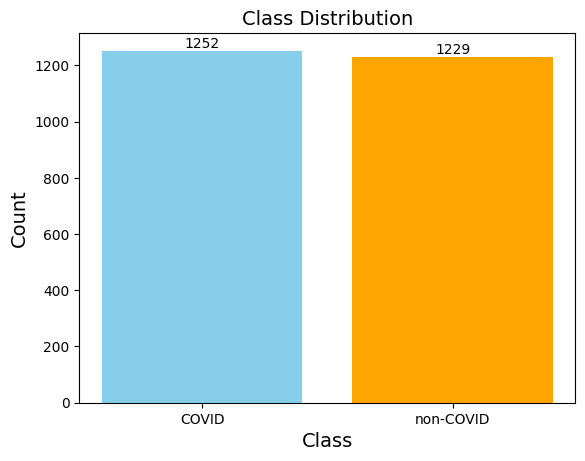

In [6]:
plot_class_distribution(data=dataframe)

In [7]:
# Splitting dataset into Training and Test
training_df, test_df = train_test_split(dataframe, test_size=4, shuffle=True, random_state=4)

# Save dataframe as CSV file format
csv_train_path = os.path.join(DATA_PATH, "train_data.csv")
training_df.to_csv(path_or_buf=csv_train_path, index=False)

csv_test_path = os.path.join(DATA_PATH, "test_data.csv")
test_df.to_csv(path_or_buf=csv_test_path, index=False)

In [8]:
class VGG16Net:
    """
    A class for extracting features from images using the VGG16 model.
    
    Attributes:
        input_shape (tuple): The shape of the input images expected by the model.
        model (keras.Model): The VGG16 model with the fully connected layers removed.
        output (keras.layers.Layer): The output layer of the model.
    """
    def __init__(self):
        """
        Initializes the VGG16Net object.
        """
        self.input_shape = INPUT_SHAPE
        self.model = VGG16(weights="imagenet", input_shape=self.input_shape, include_top=True)
        self.output = self.model.get_layer("fc2").output
        self.model = Model(self.model.input, self.output)

    # Features extraction process
    def loading_images(self, path_to_data: str) -> np.ndarray:
        """
        Preprocesses and loads an image from the specified path.

        :param path_to_data: The path to the image file.
 
        :return numpy.ndarray: The preprocessed image as a numpy array.
        """
        # Load the image and resize it to match the input shape of the model
        x = image.load_img(path=path_to_data, target_size=(self.input_shape[0], self.input_shape[1]))
        x = image.img_to_array(img=x)  # Convert image to numpy array
        x = np.expand_dims(a=x, axis=0)   # Add an extra dimension at the beginning for batch
        x = preprocess_input(x=x)  # Preprocess the image according to the model's requirements
        
        return x
    

In [9]:
# Extract features from images
def extract_feature_from_data(model, path_to_data: str) -> pd.DataFrame:
    """
    Extract features from images using the provided model and save them to a DataFrame.
    
    Args:
    :param model: An instance of the model class for feature extraction.
    :param path_to_data: The path to the CSV file containing file paths and class IDs.
    
    :return pd.DataFrame: Dataframe containing the extracted features
    """
    # Read the data from the specified path into a DataFrame
    data_df = pd.read_csv(path_to_data)
    
    # Initialize an empty list to store features
    features = []
    
    # Iterate over each row in the DataFrame
    for file_path, label in zip(data_df.file_path, data_df.id):
        # Print a message indicating which file is being processed
        print(f"\n> Extracting features from {os.path.basename(file_path)}")
        
        # Preprocess the image and extract features using the provided model
        preprocessed_image = model.loading_images(path_to_data=file_path)
        feature = model.model.predict(preprocessed_image)[0]
        normalize_feature = feature / np.linalg.norm(feature)
        
        # Append the extracted feature along with its corresponding class id to the features list
        features.append([normalize_feature, label])
        
    # Create a DataFrame to collect all the extracted features
    features_df = pd.DataFrame(data=features, columns=["features", "id"], index=None)
    # Save dataframe as CSV file format
    csv_path = os.path.join(DATA_PATH, "vgg16_extracted_feature.csv")
    features_df.to_csv(path_or_buf=csv_path, index=False)
    
    return features_df
        

In [11]:
# VGG16 model
vgg16_model = VGG16Net()

# Extracting features from dataset
features_dataframe = extract_feature_from_data(model=vgg16_model, path_to_data=TRAIN_DATA_PATH)



> Extracting features from Non-Covid (460).png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step

> Extracting features from Non-Covid (21).png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step

> Extracting features from Covid (349).png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step

> Extracting features from Covid (683).png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step

> Extracting features from Covid (1125).png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step

> Extracting features from Non-Covid (111).png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step

> Extracting features from Non-Covid (814).png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step

> Extracting features from Non-Covid (765).png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step

> Extracting features from Covid (716).png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step

> Extracting features from Covid (641).png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step

> Extracting features from Non-Covid (432).png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step

> Extracting features from Non-Covid (760).png
1/1 ━━━━━━━━━━━

In [12]:
features_dataframe.head()

,features,id
0,"[0.0, 0.0, 0.0, 0.06568082, 0.0, 0.0, 0.021264...",1
1,"[0.0, 0.0, 0.0, 0.034102485, 0.0, 0.0, 0.01646...",1
2,"[0.0, 0.0, 0.0, 0.039187834, 0.0, 0.0, 0.0, 0....",0
3,"[0.0, 0.0, 0.018394215, 0.02908138, 0.00817117...",0
4,"[0.022842476, 0.0, 0.0, 0.045528103, 0.0, 0.0,...",0


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step

> Chosen image from the test dataset: archives/non-COVID/Non-Covid (1001).png


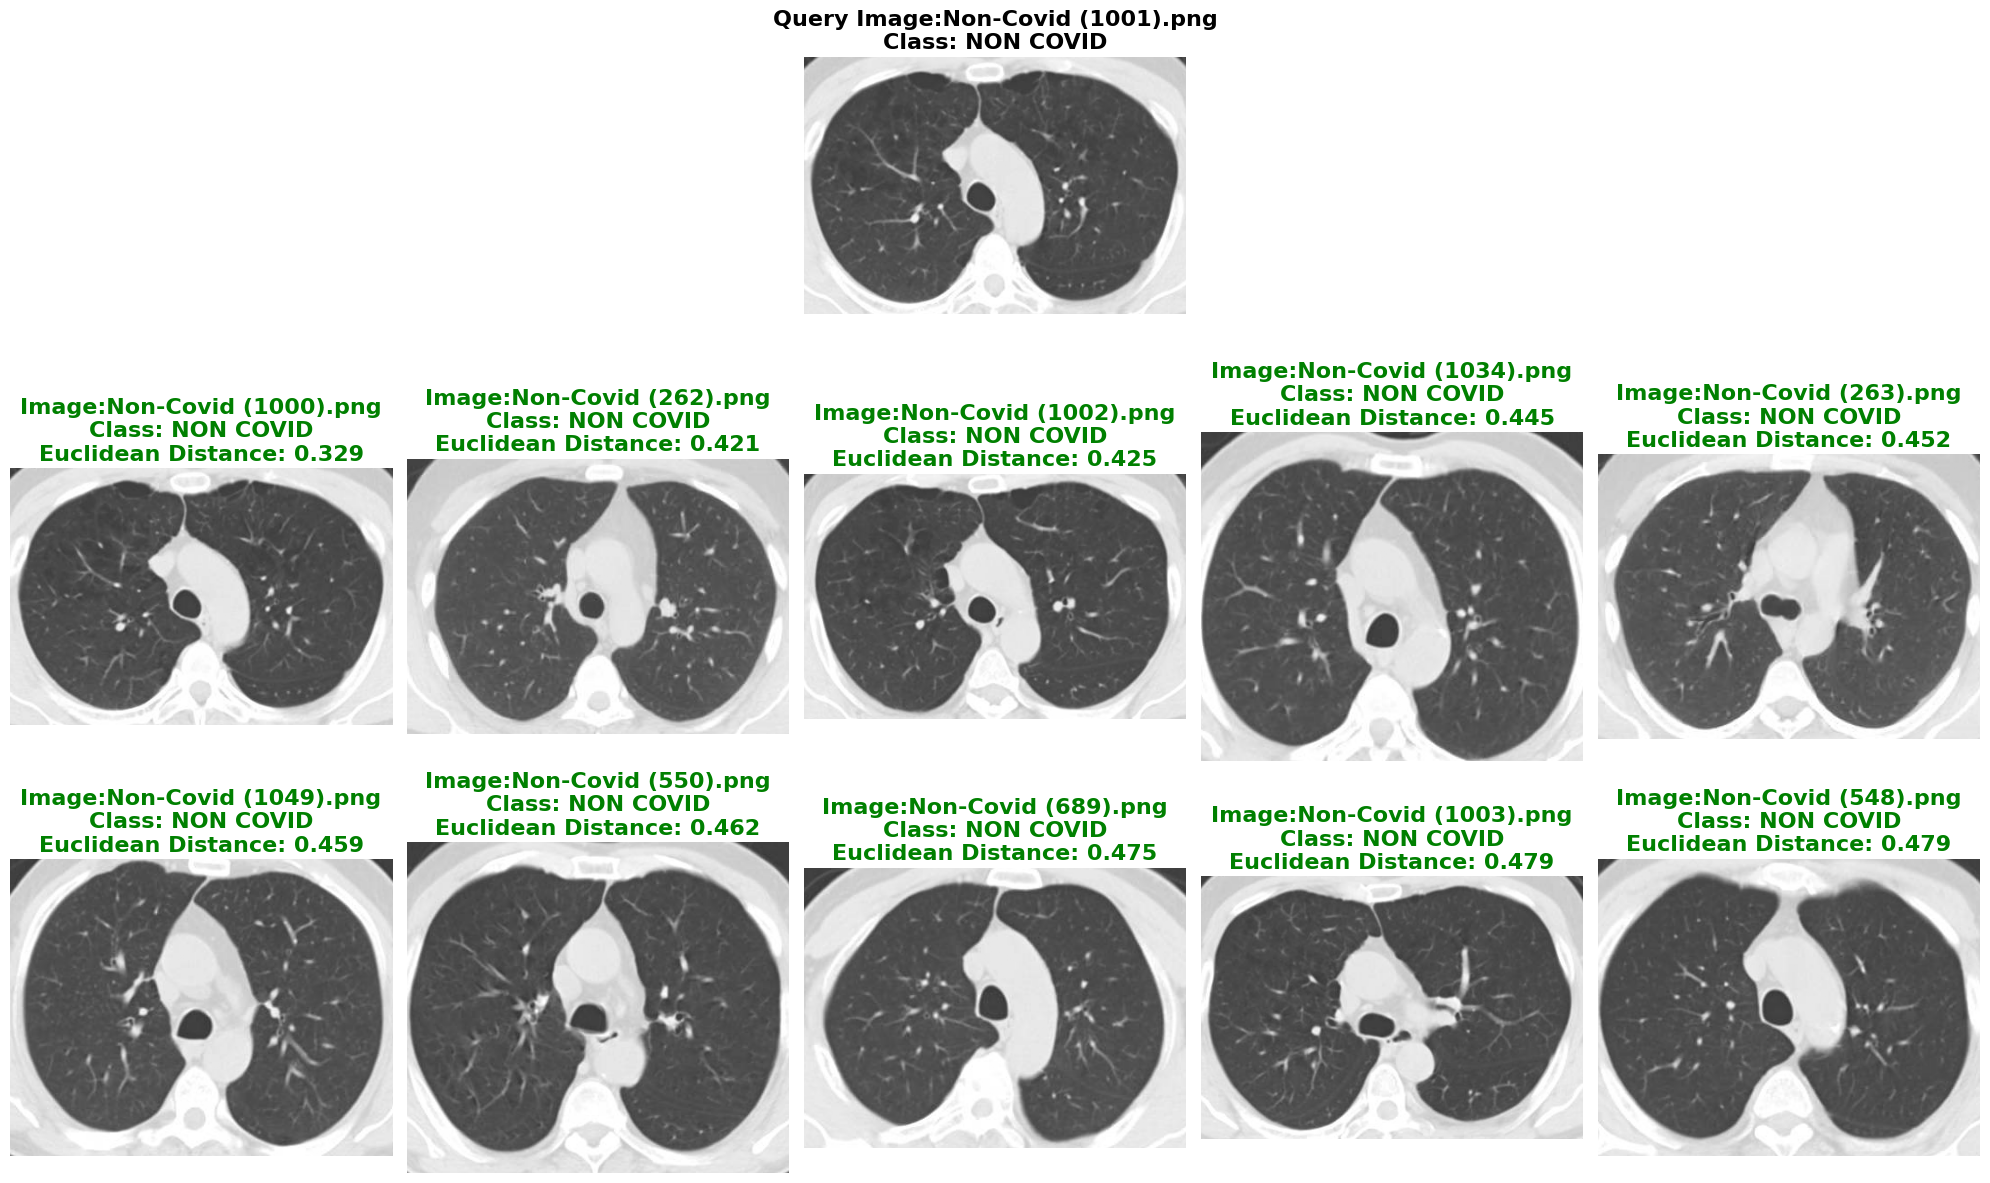

In [67]:
# Compare features based on distance metric and find similarity
def find_similar_images(features_of_query, all_features, distance_metric, comparison_number=10) -> tuple[int, int, str]:
    """
    Find similar images to the query image based on a given distance metric function.
 
    :param features_of_query: Features of the query image.
    :param all_features: Features of all images in the dataset.
    :param distance_metric: Metric to use for distance calculation. Options: "Cosine" or "Euclidean".
    :param comparison_number: number of images takes under analysis.
            Default is 10.

    :return: Indices of the most similar images and their corresponding cosine distances.
    """
    # Choose distance metric function
    if distance_metric == COSINE:
        distance_func = cosine_distances
    elif distance_metric == EUCLIDEAN:
        distance_func = euclidean_distances
    elif distance_metric == MANHATTAN:
        distance_func = manhattan_distances
    else:
        raise ValueError("Invalid distance metric. Please choose 'Cosine', 'Euclidean', 'Manhattan'.")
    
    # Calculate distances between the query image features and all other images
    distances = distance_func(features_of_query.reshape(1, -1), all_features)
    
    # Sort distances and get the indices of the closest images
    closest_indices = distances.argsort()[0][:comparison_number] 
    closest_distances = distances[0][closest_indices]
    
    return closest_indices, closest_distances, distance_metric


# Plot similar images based on chosen distance method
def plot_similar_images(path_to_query_image, query_class, similar_image_paths, similar_classes, similar_distance_parameters, distance_metric):
    """
    Plot the query image along with similar images, their distances, and associated classes.

    :param path_to_query_image: File path of the query image.
    :param query_class: Class label of the query image.
    :param similar_image_paths: List of file paths of similar images.
    :param similar_classes: List of class labels corresponding to similar images.
    :param similar_distance_parameters: List of distance values corresponding to similar images.
    :param distance_metric: Name of the distance metric adopted.
    """
    num_similar_images = len(similar_image_paths)
    num_rows = int(np.ceil(num_similar_images / 5))  # Organize in a grid structure with 5 images per row

    # Load and display the query image separately
    plt.figure(figsize=(20, (num_rows + 1) * 4))
    plt.subplot(num_rows + 1, 5, 3)  # Centered position for the query image
    plt.imshow(mpimg.imread(path_to_query_image))
    if query_class == 0:
        plt.title(f"Query Image:{os.path.basename(path_to_query_image)}\nClass: COVID", fontsize=16, weight="bold")
    else:
        plt.title(f"Query Image:{os.path.basename(path_to_query_image)}\nClass: NON COVID", fontsize=16, weight="bold")
    plt.axis("off")

    # Plot similar images and their distances in a grid
    for figure_number, (path, similar_class, distance_parameter) in enumerate(zip(similar_image_paths, similar_classes, similar_distance_parameters), 1):
        plt.subplot(num_rows + 1, 5, figure_number + 5)  # Start plotting from the 2nd row
        plt.imshow(mpimg.imread(path))
        
        if similar_class == query_class:
            title_color = "green"
        else:
            title_color = "red"
        
        if similar_class == 0:
            plt.title(f"Image:{os.path.basename(path)}\nClass: COVID\n{distance_metric} Distance: {distance_parameter:.3f}", color=title_color, fontsize=16, weight="bold")
        else:
            plt.title(f"Image:{os.path.basename(path)}\nClass: NON COVID\n{distance_metric} Distance: {distance_parameter:.3f}", color=title_color, fontsize=16, weight="bold")
        plt.axis("off")

    plt.tight_layout()
    
    # Save the plot to path
    plot_path = os.path.join(PLOT_PATH, f"{os.path.basename(path_to_query_image).split(".")[0]}_{distance_metric}.png") 
    plt.savefig(plot_path, dpi=96)
    
    # Display plot
    plt.show()
    

# Choose which of the images to analyze and how
def choose_query_file_and_distance(query_dataset):
    """
    Display available files from the test dataset and prompt the user to choose one.
    
    :param query_dataset: DataFrame containing test data.
    :return: File path, corresponding ID, and chosen distance function by the user.
    """
    query_file_path = None
    query_id = None
    distance_function = None
    
    # Construct the prompt message for file selection
    file_names = [os.path.basename(path) for path in query_dataset["file_path"]]
    file_prompt_message = (f"Enter the index of the file you want to choose.\n"
                           f"Options:[index / file]\n\n")
    for i, file_name in enumerate(file_names):
        file_prompt_message += f"{i} - {file_name}\n"
    
    while True:
        file_choice = input(file_prompt_message)
        if file_choice.strip() == "":
            print("No input provided. Please enter a valid index!")
            continue
        
        try:
            file_choice = int(file_choice)
            if file_choice < 0 or file_choice >= len(query_dataset):
                print("Invalid index. Please choose a valid index!")
                continue
            else:
                query_file_path = query_dataset.iloc[file_choice]["file_path"]
                query_id = query_dataset.iloc[file_choice]["id"]
                break
        except ValueError:
            print("Invalid input. Please enter a valid index!")
    
    # Construct the prompt message for distance function selection
    distance_prompt_message = ("Choose the distance function:\n"
                               "1 - Cosine\n"
                               "2 - Euclidean\n"
                               "3 - Manhattan\n")
    
    while True:
        distance_choice = input(distance_prompt_message)
        if distance_choice not in {"1", "2", "3"}:
            print("Invalid choice. Please enter a valid number!")
            continue
        else:
            if distance_choice == "1":
                distance_function = "Cosine"
            elif distance_choice == "2":
                distance_function = "Euclidean"
            elif distance_choice == "3":
                distance_function = "Manhattan"
            break
    
    return query_file_path, query_id, distance_function
 
## ****************************************************************************************************** ##
## ************************************ FROM QUERY PLOT SIMILAR IMAGES ********************************** ##
## ****************************************************************************************************** ##

# Read the data from the specified path into a DataFrame
train_data = pd.read_csv(filepath_or_buffer=TRAIN_DATA_PATH)
test_data = pd.read_csv(filepath_or_buffer=TEST_DATA_PATH)

# Choose a file from the test dataset
chosen_file_path, chosen_id, distance = choose_query_file_and_distance(query_dataset=test_data)

# Load the query image
query_features = vgg16_model.loading_images(path_to_data=chosen_file_path)
query_features = vgg16_model.model.predict(x=query_features)[0]
query_features = query_features / np.linalg.norm(x=query_features)

# Separate features and labels
X = np.array(features_dataframe["features"].to_list())
# y = np.array(features_dataframe["id"].to_list())

# Calculate cosine distances and find similar images
similar_indices, similar_distances, function = find_similar_images(features_of_query=query_features, all_features=X, distance_metric=distance)

# Print info.
print("\n> Chosen image from the test dataset:", chosen_file_path)

# Plot similar images with classes
plot_similar_images(path_to_query_image=chosen_file_path, query_class=chosen_id, 
                    similar_image_paths=[train_data.iloc[index]["file_path"] for index in similar_indices],
                    similar_classes=[train_data.iloc[index]["id"] for index in similar_indices], 
                    similar_distance_parameters=similar_distances,
                    distance_metric=function)
